In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord
import gc
import numpy as np
import jax.numpy as jnp
from astropy.io import fits

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom

import tempfile
import getpass

import scarlet2

In [2]:
username = getpass.getuser()
print('username: ', username)

userdir = '/deleted-sundays/' + username
if not os.path.exists(userdir):
    os.makedirs(userdir)
    print('Created ', userdir)
else:
    print('Directory already existed: ', userdir)

username:  charlotteward
Directory already existed:  /deleted-sundays/charlotteward


In [3]:
tempdir = userdir + '/dp02_13a_temp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    print('Created ', tempdir)
else:
    print('Directory already existed: ', tempdir)

Directory already existed:  /deleted-sundays/charlotteward/dp02_13a_temp


In [4]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, psf_size=63, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)
    newWCS = cutout_image.getWcs()
    anchor_image = butler.get(datasetType, #parameters=parameters,
                              dataId=coaddId)#butler.get('deepCoadd_calexp', dataId=anchor_dataId)
    anchor_wcs = butler.get('deepCoadd.wcs', dataId=coaddId)#anchor_dataId)
    center = geom.SpherePoint(ra, dec, geom.degrees)
    anchor_info = anchor_image.getInfo()
    center_pix_anchor = anchor_wcs.skyToPixel(center)

    newimage_info = cutout_image.getInfo()
    center_pix_newimage = newWCS.skyToPixel(center)
    point_tuple = (center_pix_anchor[0], center_pix_anchor[1])
    point_image = geom.Point2D(point_tuple)
    anchor_psf = anchor_image.getPsf()
    psf_shape = anchor_psf.computeShape(point_image)

    newimage_psf = cutout_image.getPsf()
    point_tuple = (center_pix_newimage[0], center_pix_newimage[1])
    point_image = geom.Point2D(point_tuple)
    psf_shape = newimage_psf.computeShape(point_image)
    psf_img = anchor_psf.computeImage(point_image).convertF()
    psf_out = psf_img.array
    psf_pad_x = int((psf_size-psf_out.shape[0])/2)
    psf_pad_y = int((psf_size-psf_out.shape[1])/2)
    psf_out = np.pad(psf_out,((psf_pad_x, psf_pad_x),(psf_pad_y, psf_pad_y)), 'constant')
    return cutout_image, psf_out, tractInfo.getId(), patch

In [5]:
afwDisplay.setDefaultBackend('matplotlib')

In [6]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [7]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

In [8]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

In [9]:
ra = 60.2901612 
dec = -44.3420602

In [10]:
cutout_image_g, psf_g, tract_g, patch_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=121)
cutout_image_r, psf_r, tract_r, patch_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=121)
cutout_image_i, psf_i, tract_i, patch_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=121)
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

im_arr = jnp.asarray([cutout_image_g.image.array,cutout_image_r.image.array,cutout_image_i.image.array])
weight_arr = jnp.asarray([1/cutout_image_g.variance.array,1/cutout_image_r.variance.array,1/cutout_image_i.variance.array])
psf_arr = jnp.stack((psf_g,psf_r,psf_i))



In [11]:
filename = os.path.join(tempdir,'cutout_g.fits')
cutout_image_g.writeFits(filename)
f=fits.open(filename)
wcs_g = WCS(f[1].header)
filename = os.path.join(tempdir,'cutout_r.fits')
cutout_image_r.writeFits(filename)
f=fits.open(filename)
wcs_r = WCS(f[1].header)
filename = os.path.join(tempdir,'cutout_i.fits')
cutout_image_g.writeFits(filename)
f=fits.open(filename)
wcs_i = WCS(f[1].header)

In [12]:
obs = scarlet2.Observation(im_arr,
                           weights=weight_arr,
                           psf=scarlet2.ArrayPSF(jnp.array(psf_arr)),
                           wcs=wcs_r,
                           channels=['g','r','i'])

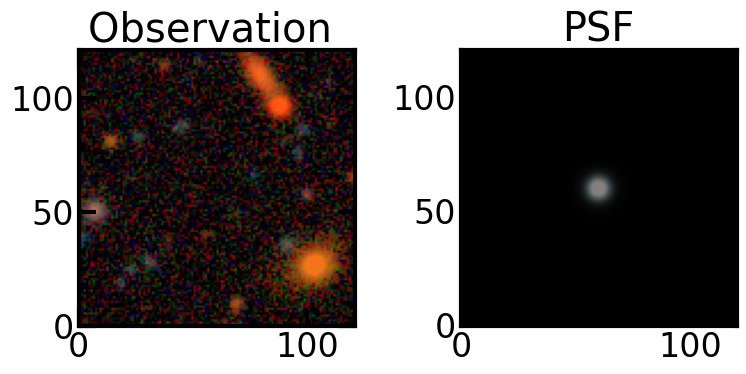

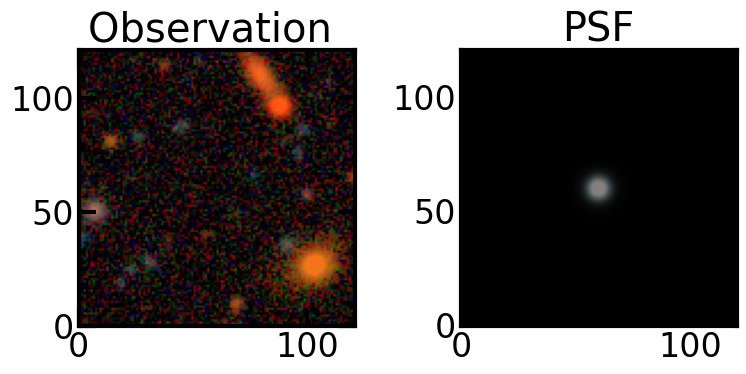

In [14]:
norm = scarlet2.plot.AsinhAutomaticNorm(obs)
scarlet2.plot.observation(obs, norm=norm, show_psf=True, add_labels=True)

In [15]:
model_psf = scarlet2.GaussianPSF(sigma=0.5)
model_frame = scarlet2.Frame.from_observations(obs, model_psf=model_psf)

In [16]:
wcs_g = cutout_image_g.getWcs()
x0 = float(cutout_image_g.getX0())
y0 = float(cutout_image_g.getY0())
width = cutout_image_g.getWidth()
height = cutout_image_g.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs_g.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())

In [17]:
service = get_tap_service("tap")

In [18]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " +\
        "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +\
        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +\
        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +\
        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " +\
        "tract = " + str(tract_g) + " AND patch = " + str(patch_g)
print(query)

SELECT objectId, coord_ra, coord_dec, x, y, tract, patch FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), POLYGON('ICRS', 60.294745861397104, -44.34540102668026, 60.285347435992776, -44.345341420877375, 60.28543062036926, -44.33862017548718, 60.294827977384244, -44.33867976741578)) = 1 AND tract = 2902 AND patch = 12


In [19]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [20]:
results = job.fetch_result()
print(len(results))
source = results.to_table()
coords = SkyCoord(ra=np.asarray(source['coord_ra'],dtype=float) * u.deg, dec=np.asarray(source['coord_dec'],dtype=float) * u.deg)

39


In [21]:
with scarlet2.Scene(model_frame) as scene:
    for i, center in enumerate(coords):    
        #Now initialize background sources that are static across epochs
        try:
            spectrum, morph = scarlet2.init.from_gaussian_moments(obs, center)
            # If the boxes produced are too small, try adjusting the SNR or box_size arguments https://github.com/pmelchior/scarlet2/blob/8a7bf55f4908a402ba7e43b4b564886aa4ad2a4b/src/scarlet2/init.py#L205
        except:# IndexError:
            morph = scarlet2.init.compact_morphology()
            spectrum = scarlet2.init.pixel_spectrum(obs, center)
        spectrum = jnp.clip(spectrum,a_min=1e-6,a_max=1e6)
        # the host is barely resolved and the data are noisy:
        # use a starlet morphology for extra stability (esp to noise)
        morph = scarlet2.StarletMorphology.from_image(morph)
        # Select the transient-free epochs to initialize amplitudes for the static source
        # These will be shared across all epochs
        scarlet2.Source(
            center, spectrum, morph
        )
       

Zero or negative spectrum [-0.30549866  0.49143922  1.0982524 ] at [39.219543 55.163776]
Zero or negative spectrum [ 1.3523787  0.9955087 -0.6875324] at [86.734436 43.707596]
Zero or negative spectrum [-0.13361676  0.5336771  -0.22116873] at [100.25322 102.63996]
Zero or negative spectrum [-0.01165995  0.04852551 -0.0217494 ] at <SkyCoord (ICRS): (ra, dec) in deg
    (60.2868423, -44.3397817)>
Zero or negative spectrum [-0.3230656   0.15591018  0.7325144 ] at [26.96945  81.659355]
Zero or negative spectrum [-0.23805077  0.5413148   1.0605804 ] at [16.89178 85.08017]
Zero or negative spectrum [-0.0207733   0.04921998  0.10429587] at <SkyCoord (ICRS): (ra, dec) in deg
    (60.288149, -44.3444209)>
Zero or negative spectrum [-0.05289064  0.6026143   1.5037842 ] at [39.110233 54.700603]
Zero or negative spectrum [ 1.3523787  0.9955087 -0.6875324] at [86.88099  43.828625]
Zero or negative spectrum [ 0.77232337  0.7561103  -0.52970433] at [64.92683 76.11251]


In [22]:
from numpyro.distributions import constraints

morph_step = lambda p: scarlet2.relative_step(p, factor=1e-2)
SED_step = lambda p: scarlet2.relative_step(p, factor=1e-2)

parameters = scene.make_parameters()

for i, center in enumerate(coords):
        # galaxy parameters
        parameters += scarlet2.Parameter(
            scene.sources[i].spectrum, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=SED_step
        )
        parameters += scarlet2.Parameter(
            scene.sources[i].morphology.coeffs,
            name=f"morph.{i}",
            stepsize=morph_step,
        )


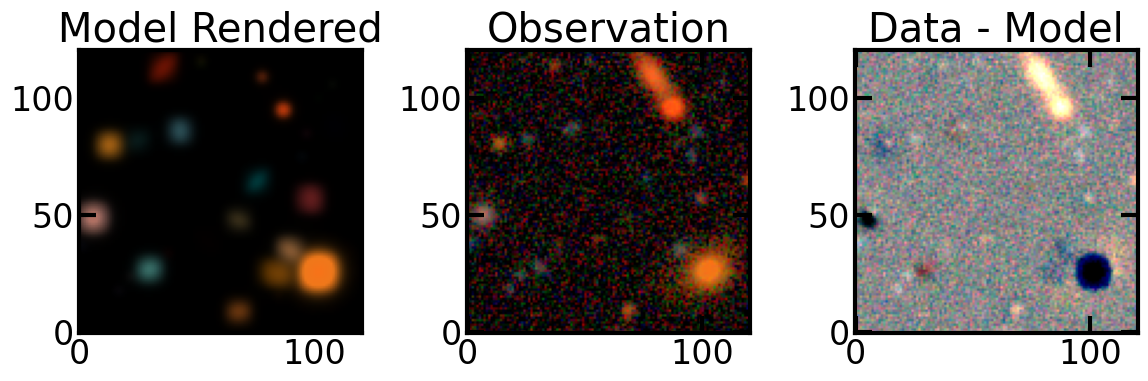

In [23]:
scarlet2.plot.scene(
    scene,
    observation=obs,
    norm=norm,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=False,
    add_boxes=False,
    split_channels=False,
    box_kwargs={"edgecolor": "red", "facecolor": "none"},
    label_kwargs={"color": "red"},
)
plt.show()

In [ ]:
# Fit the scene
stepnum = 2000
scene_ = scene.fit(obs, parameters, max_iter=stepnum, e_rel=1e-7, progress_bar=False)

In [ ]:
# Plot the model, for each epoch
scarlet2.plot.scene(
    scene_,
    observation=obs,
    norm=norm,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=False,
    add_boxes=True,
    split_channels=False,
    box_kwargs={"edgecolor": "red", "facecolor": "none"},
    label_kwargs={"color": "red"},
)
plt.show()


In [ ]:
#Print the best fitting fluxes
print("----------------- {}".format(channels))
for k, src in enumerate(scene_.sources):
    print("Source {}, Fluxes: {}".format(k, scarlet2.measure.flux(src)))